# NB 04: Module Functional Annotation

Label each ICA module with biological function using enrichment analysis.

**Part 1 (JupyterHub)**: Extract KEGG, SEED, domain, and specific phenotype
annotations from Spark.

**Part 2 (local)**: Fisher exact test enrichment for each module.

Run Part 1 on JupyterHub first, then Part 2 can run locally.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats as scipy_stats
from statsmodels.stats.multitest import multipletests

DATA_DIR = Path('../data')
ANNOT_DIR = DATA_DIR / 'annotations'
MODULE_DIR = DATA_DIR / 'modules'
ANNOT_DIR.mkdir(parents=True, exist_ok=True)

pilots = pd.read_csv(DATA_DIR / 'pilot_organisms.csv')
pilot_ids = pilots['orgId'].tolist()
print(f"Pilot organisms: {pilot_ids}")

Pilot organisms: ['DvH', 'Btheta', 'Methanococcus_S2', 'psRCH2', 'Putida', 'Phaeo', 'Marino', 'pseudo3_N2E3', 'Koxy', 'Cola', 'WCS417', 'Caulo', 'SB2B', 'pseudo6_N2E2', 'Dino', 'pseudo5_N2C3_1', 'Miya', 'Pedo557', 'MR1', 'Keio', 'Korea', 'PV4', 'pseudo1_N1B4', 'acidovorax_3H11', 'SynE', 'Methanococcus_JJ', 'BFirm', 'Kang', 'ANA3', 'Cup4G11', 'pseudo13_GW456_L13', 'Ponti']


## Part 1: Extract Annotations from Spark

**Run this section on JupyterHub.**

In [2]:
# Initialize Spark (comment out if running Part 2 locally)
try:
    spark = get_spark_session()
    HAS_SPARK = True
    print(f"Spark version: {spark.version}")
except Exception:
    HAS_SPARK = False
    print("No Spark available — running Part 2 only (local mode)")

Spark version: 4.0.1


In [3]:
if HAS_SPARK:
    for org_id in pilot_ids:
        # KEGG annotations (join through besthitkegg — keggmember has no orgId/locusId)
        kegg_file = ANNOT_DIR / f'{org_id}_kegg.csv'
        if not (kegg_file.exists() and kegg_file.stat().st_size > 0):
            kegg = spark.sql(f"""
                SELECT bk.locusId, km.kgroup, kd.desc as kgroup_desc,
                       ke.ecnum as ec
                FROM kescience_fitnessbrowser.besthitkegg bk
                JOIN kescience_fitnessbrowser.keggmember km
                    ON bk.keggOrg = km.keggOrg AND bk.keggId = km.keggId
                LEFT JOIN kescience_fitnessbrowser.kgroupdesc kd
                    ON km.kgroup = kd.kgroup
                LEFT JOIN kescience_fitnessbrowser.kgroupec ke
                    ON km.kgroup = ke.kgroup
                WHERE bk.orgId = '{org_id}'
            """).toPandas()
            kegg.to_csv(kegg_file, index=False)
            print(f"KEGG: {org_id} — {len(kegg)} annotations")
        else:
            print(f"CACHED: {org_id} KEGG")

        # SEED annotations (seedclass has no subsystem columns — just use seed_desc)
        seed_file = ANNOT_DIR / f'{org_id}_seed.csv'
        if not (seed_file.exists() and seed_file.stat().st_size > 0):
            seed = spark.sql(f"""
                SELECT locusId, seed_desc
                FROM kescience_fitnessbrowser.seedannotation
                WHERE orgId = '{org_id}'
            """).toPandas()
            seed.to_csv(seed_file, index=False)
            print(f"SEED: {org_id} — {len(seed)} annotations")
        else:
            print(f"CACHED: {org_id} SEED")

        # Domain annotations
        domain_file = ANNOT_DIR / f'{org_id}_domains.csv'
        if not (domain_file.exists() and domain_file.stat().st_size > 0):
            domains = spark.sql(f"""
                SELECT locusId, domainDb, domainId, domainName,
                       definition, geneSymbol, ec
                FROM kescience_fitnessbrowser.genedomain
                WHERE orgId = '{org_id}'
            """).toPandas()
            domains.to_csv(domain_file, index=False)
            print(f"Domains: {org_id} — {len(domains)} annotations")
        else:
            print(f"CACHED: {org_id} domains")

        # Specific phenotypes
        pheno_file = ANNOT_DIR / f'{org_id}_specific_phenotypes.csv'
        if not (pheno_file.exists() and pheno_file.stat().st_size > 0):
            pheno = spark.sql(f"""
                SELECT sp.locusId, sp.expName,
                       e.expDesc, e.expGroup, e.condition_1
                FROM kescience_fitnessbrowser.specificphenotype sp
                JOIN kescience_fitnessbrowser.experiment e
                    ON sp.orgId = e.orgId AND sp.expName = e.expName
                WHERE sp.orgId = '{org_id}'
            """).toPandas()
            pheno.to_csv(pheno_file, index=False)
            print(f"Phenotypes: {org_id} — {len(pheno)} entries")
        else:
            print(f"CACHED: {org_id} phenotypes")

CACHED: DvH KEGG
CACHED: DvH SEED
CACHED: DvH domains
CACHED: DvH phenotypes
CACHED: Btheta KEGG
CACHED: Btheta SEED
CACHED: Btheta domains
CACHED: Btheta phenotypes
CACHED: Methanococcus_S2 KEGG
CACHED: Methanococcus_S2 SEED
CACHED: Methanococcus_S2 domains
CACHED: Methanococcus_S2 phenotypes
CACHED: psRCH2 KEGG
CACHED: psRCH2 SEED
CACHED: psRCH2 domains
CACHED: psRCH2 phenotypes
CACHED: Putida KEGG
CACHED: Putida SEED
CACHED: Putida domains
CACHED: Putida phenotypes
CACHED: Phaeo KEGG
CACHED: Phaeo SEED
CACHED: Phaeo domains
CACHED: Phaeo phenotypes
CACHED: Marino KEGG
CACHED: Marino SEED
CACHED: Marino domains
CACHED: Marino phenotypes
CACHED: pseudo3_N2E3 KEGG
CACHED: pseudo3_N2E3 SEED
CACHED: pseudo3_N2E3 domains
CACHED: pseudo3_N2E3 phenotypes
CACHED: Koxy KEGG
CACHED: Koxy SEED
CACHED: Koxy domains
CACHED: Koxy phenotypes
CACHED: Cola KEGG
CACHED: Cola SEED
CACHED: Cola domains
CACHED: Cola phenotypes
CACHED: WCS417 KEGG
CACHED: WCS417 SEED
CACHED: WCS417 domains
CACHED: WCS417 

## Part 2: Enrichment Analysis

Fisher exact test for each annotation term vs module membership.

In [4]:
def enrichment_analysis(module_genes, all_genes, annotation_map, min_annotated=2):
    """Fisher exact test enrichment for a single module.
    
    Parameters
    ----------
    module_genes : set
        Genes in the module.
    all_genes : set
        All genes in the organism.
    annotation_map : dict
        {term: set_of_genes} mapping.
    min_annotated : int
        Minimum annotated genes in module for testing.
    
    Returns
    -------
    results : list of dict
        Enrichment results per term.
    """
    results = []
    n_total = len(all_genes)
    n_module = len(module_genes)
    
    for term, term_genes in annotation_map.items():
        term_genes = term_genes & all_genes  # intersect with valid genes
        overlap = module_genes & term_genes
        
        if len(overlap) < min_annotated:
            continue
        
        # 2x2 contingency table
        a = len(overlap)                          # in module AND annotated
        b = len(module_genes - term_genes)         # in module NOT annotated
        c = len(term_genes - module_genes)          # NOT in module but annotated
        d = n_total - len(module_genes | term_genes)  # neither
        
        odds_ratio, p_value = scipy_stats.fisher_exact([[a, b], [c, d]],
                                                        alternative='greater')
        results.append({
            'term': term,
            'n_overlap': a,
            'n_module': n_module,
            'n_term': len(term_genes),
            'odds_ratio': odds_ratio,
            'p_value': p_value
        })
    
    return results

In [5]:
for org_id in pilot_ids:
    out_file = MODULE_DIR / f'{org_id}_module_annotations.csv'
    cond_file = MODULE_DIR / f'{org_id}_module_conditions.csv'
    
    if out_file.exists() and out_file.stat().st_size > 0:
        print(f"CACHED: {org_id} annotations")
        continue
    
    print(f"\nAnnotating {org_id} modules...")
    
    # Load membership
    membership = pd.read_csv(MODULE_DIR / f'{org_id}_gene_membership.csv', index_col=0)
    all_genes = set(membership.index.astype(str))
    module_names = membership.columns.tolist()
    
    # Load annotations and build term->gene maps
    annotation_maps = {}
    
    # KEGG
    kegg_file = ANNOT_DIR / f'{org_id}_kegg.csv'
    if kegg_file.exists():
        kegg = pd.read_csv(kegg_file)
        kegg_map = kegg.groupby('kgroup')['locusId'].apply(lambda x: set(x.astype(str))).to_dict()
        annotation_maps['KEGG'] = kegg_map
    
    # SEED (group by seed_desc — seedclass has no subsystem hierarchy)
    seed_file = ANNOT_DIR / f'{org_id}_seed.csv'
    if seed_file.exists():
        seed = pd.read_csv(seed_file).dropna(subset=['seed_desc'])
        if len(seed) > 0:
            seed_map = seed.groupby('seed_desc')['locusId'].apply(
                lambda x: set(x.astype(str))).to_dict()
            # Keep terms with 2+ genes
            annotation_maps['SEED'] = {k: v for k, v in seed_map.items() if len(v) >= 2}
    
    # Domains (TIGRFam and PFam)
    domain_file = ANNOT_DIR / f'{org_id}_domains.csv'
    if domain_file.exists():
        domains = pd.read_csv(domain_file)
        domains['locusId'] = domains['locusId'].astype(str)
        tigr = domains[domains['domainDb'] == 'TIGRFam']
        if len(tigr) > 0:
            tigr_map = tigr.groupby('domainId')['locusId'].apply(
                lambda x: set(x.astype(str))).to_dict()
            annotation_maps['TIGRFam'] = tigr_map
        pfam = domains[domains['domainDb'] == 'PFam']
        if len(pfam) > 0:
            pfam_map = pfam.groupby('domainId')['locusId'].apply(
                lambda x: set(x.astype(str))).to_dict()
            annotation_maps['PFam'] = pfam_map
    
    # Run enrichment for each module
    all_results = []
    for mod in module_names:
        mod_genes = set(membership.index[membership[mod] == 1].astype(str))
        if len(mod_genes) == 0:
            continue
        
        for db_name, term_map in annotation_maps.items():
            results = enrichment_analysis(mod_genes, all_genes, term_map)
            for r in results:
                r['module'] = mod
                r['database'] = db_name
            all_results.extend(results)
    
    if all_results:
        enrich_df = pd.DataFrame(all_results)
        # FDR correction
        reject, fdr, _, _ = multipletests(enrich_df['p_value'], method='fdr_bh')
        enrich_df['fdr'] = fdr
        enrich_df['significant'] = reject
        enrich_df = enrich_df.sort_values(['module', 'fdr'])
        enrich_df.to_csv(out_file, index=False)
        
        n_sig = enrich_df['significant'].sum()
        n_modules_annotated = enrich_df[enrich_df['significant']]['module'].nunique()
        print(f"  {n_sig} significant enrichments across {n_modules_annotated} modules")
    else:
        print(f"  No enrichments found")
    
    # Map module activity to experiment conditions
    profiles = pd.read_csv(MODULE_DIR / f'{org_id}_module_profiles.csv', index_col=0)
    exp_meta = pd.read_csv(ANNOT_DIR / f'{org_id}_experiments.csv')
    
    condition_results = []
    for mod in profiles.index:
        activity = profiles.loc[mod]
        # Top 5 most activated experiments
        top_activated = activity.abs().nlargest(5)
        for exp_name, act_value in top_activated.items():
            exp_info = exp_meta[exp_meta['expName'] == exp_name]
            if len(exp_info) > 0:
                condition_results.append({
                    'module': mod,
                    'expName': exp_name,
                    'activity': float(activity[exp_name]),
                    'abs_activity': float(act_value),
                    'expDesc': exp_info.iloc[0].get('expDesc', ''),
                    'expGroup': exp_info.iloc[0].get('expGroup', ''),
                    'condition_1': exp_info.iloc[0].get('condition_1', '')
                })
    
    if condition_results:
        cond_df = pd.DataFrame(condition_results)
        cond_df.to_csv(cond_file, index=False)
        print(f"  Saved condition mappings")


Annotating DvH modules...


  133 significant enrichments across 31 modules
  Saved condition mappings

Annotating Btheta modules...


  134 significant enrichments across 24 modules
  Saved condition mappings

Annotating Methanococcus_S2 modules...


  40 significant enrichments across 10 modules
  Saved condition mappings

Annotating psRCH2 modules...


  177 significant enrichments across 35 modules
  Saved condition mappings

Annotating Putida modules...


  250 significant enrichments across 36 modules
  Saved condition mappings

Annotating Phaeo modules...


  170 significant enrichments across 32 modules
  Saved condition mappings

Annotating Marino modules...


  162 significant enrichments across 31 modules
  Saved condition mappings

Annotating pseudo3_N2E3 modules...


  307 significant enrichments across 34 modules
  Saved condition mappings

Annotating Koxy modules...


  173 significant enrichments across 34 modules
  Saved condition mappings

Annotating Cola modules...


  197 significant enrichments across 28 modules
  Saved condition mappings

Annotating WCS417 modules...


  250 significant enrichments across 32 modules
  Saved condition mappings

Annotating Caulo modules...


  112 significant enrichments across 24 modules
  Saved condition mappings

Annotating SB2B modules...


  230 significant enrichments across 31 modules
  Saved condition mappings

Annotating pseudo6_N2E2 modules...


  250 significant enrichments across 36 modules
  Saved condition mappings

Annotating Dino modules...


  169 significant enrichments across 27 modules
  Saved condition mappings

Annotating pseudo5_N2C3_1 modules...


  334 significant enrichments across 41 modules
  Saved condition mappings

Annotating Miya modules...


  165 significant enrichments across 26 modules
  Saved condition mappings

Annotating Pedo557 modules...


  204 significant enrichments across 31 modules
  Saved condition mappings

Annotating MR1 modules...


  191 significant enrichments across 36 modules
  Saved condition mappings

Annotating Keio modules...


  176 significant enrichments across 31 modules
  Saved condition mappings

Annotating Korea modules...


  121 significant enrichments across 19 modules
  Saved condition mappings

Annotating PV4 modules...


  199 significant enrichments across 25 modules
  Saved condition mappings

Annotating pseudo1_N1B4 modules...


  112 significant enrichments across 17 modules
  Saved condition mappings

Annotating acidovorax_3H11 modules...


  160 significant enrichments across 29 modules
  Saved condition mappings

Annotating SynE modules...


  60 significant enrichments across 14 modules
  Saved condition mappings

Annotating Methanococcus_JJ modules...


  63 significant enrichments across 9 modules
  Saved condition mappings

Annotating BFirm modules...


  145 significant enrichments across 27 modules
  Saved condition mappings

Annotating Kang modules...


  97 significant enrichments across 18 modules
  Saved condition mappings

Annotating ANA3 modules...


  184 significant enrichments across 31 modules
  Saved condition mappings

Annotating Cup4G11 modules...


  244 significant enrichments across 31 modules
  Saved condition mappings

Annotating pseudo13_GW456_L13 modules...


  191 significant enrichments across 33 modules
  Saved condition mappings

Annotating Ponti modules...


  171 significant enrichments across 27 modules
  Saved condition mappings


In [6]:
# Summary: top enrichments per organism
for org_id in pilot_ids:
    ann_file = MODULE_DIR / f'{org_id}_module_annotations.csv'
    if not ann_file.exists() or ann_file.stat().st_size < 10:
        continue
    ann = pd.read_csv(ann_file)
    if len(ann) == 0:
        continue
    sig = ann[ann['significant']]
    print(f"\n{org_id}: {len(sig)} significant enrichments")
    # Show top enrichment per module
    top = sig.groupby('module').first().reset_index()
    if len(top) > 0:
        print(top[['module', 'database', 'term', 'n_overlap', 'odds_ratio', 'fdr']].head(10).to_string(index=False))


DvH: 133 significant enrichments
module database      term  n_overlap  odds_ratio          fdr
  M000     PFam   PF12399          2  455.166667 1.770892e-04
  M002     PFam   PF00590          4  725.600000 2.877661e-07
  M003     PFam   PF00072          4   27.220513 2.783908e-04
  M006     PFam   PF00994          3  340.500000 1.845777e-05
  M007     PFam   PF13186          3  291.642857 2.266124e-05
  M008     PFam   PF01061          2         inf 4.120635e-05
  M010     PFam   PF02653          2  303.333333 2.534944e-04
  M011     PFam   PF00460          7  437.906977 4.820529e-10
  M012  TIGRFam TIGR01539          3         inf 3.966784e-06
  M013     PFam   PF02508          2         inf 1.770892e-04

Btheta: 134 significant enrichments
module database                                                                  term  n_overlap  odds_ratio          fdr
  M000     PFam                                                               PF01915          2   44.175824 3.270124e-03
  M


SynE: 60 significant enrichments
module database                                    term  n_overlap  odds_ratio      fdr
  M000     KEGG                                  K01090          2         inf 0.003765
  M001     KEGG                                  K02005          2  138.444444 0.003765
  M003     KEGG                                  K03086          2         inf 0.003765
  M004     PFam                                 PF00005          2   11.974194 0.024968
  M005     PFam                                 PF00528          2   11.272727 0.026186
  M006     PFam                                 PF14559          2   11.236364 0.026865
  M008  TIGRFam                               TIGR01184          2   54.231884 0.007311
  M009     PFam                                 PF00999          2   51.944444 0.007446
  M010     PFam                                 PF01022          2  117.437500 0.003765
  M013     SEED Two-component system response regulator          2         inf 0.00376

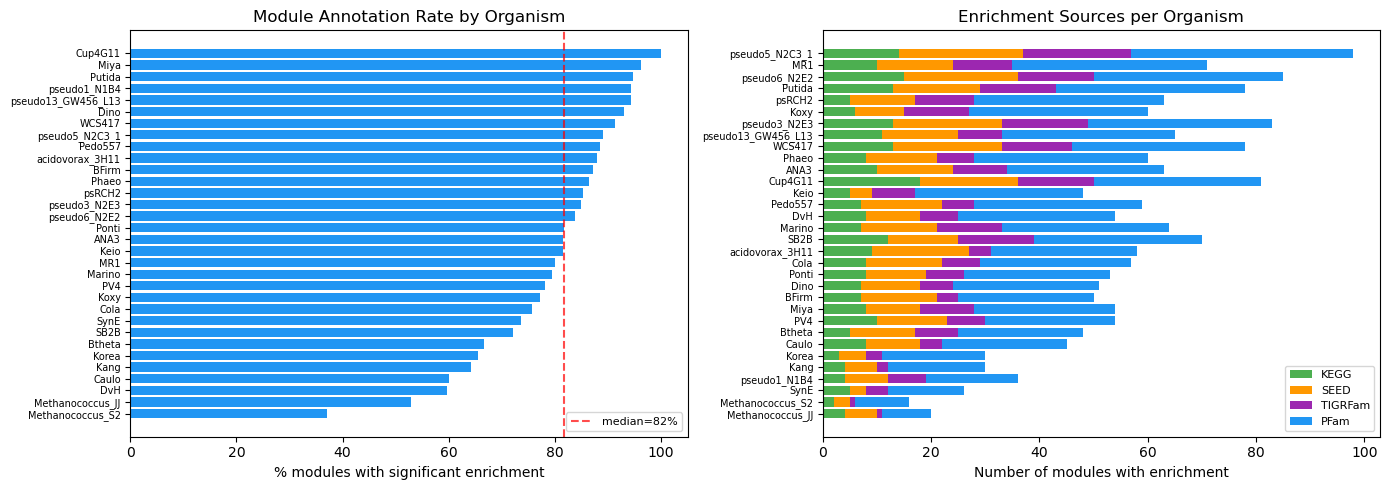

Mean annotation rate: 79.5%
Saved: figures/enrichment_summary.png


In [7]:
import matplotlib.pyplot as plt

FIG_DIR = Path('../figures')

# Collect enrichment stats per organism
enrich_stats = []
for org_id in pilot_ids:
    ann_file = MODULE_DIR / f'{org_id}_module_annotations.csv'
    member_file = MODULE_DIR / f'{org_id}_gene_membership.csv'
    if not ann_file.exists() or ann_file.stat().st_size < 10 or not member_file.exists():
        continue
    ann = pd.read_csv(ann_file)
    if len(ann) == 0:
        continue
    membership = pd.read_csv(member_file, index_col=0)
    n_modules = len(membership.columns)
    sig = ann[ann['significant']]
    modules_annotated = sig['module'].nunique()
    
    # Count by database
    db_counts = sig.groupby('database')['module'].nunique()
    enrich_stats.append({
        'orgId': org_id,
        'n_modules': n_modules,
        'n_annotated': modules_annotated,
        'pct_annotated': 100 * modules_annotated / n_modules,
        'n_kegg': db_counts.get('KEGG', 0),
        'n_seed': db_counts.get('SEED', 0),
        'n_tigrfam': db_counts.get('TIGRFam', 0),
        'n_pfam': db_counts.get('PFam', 0),
    })

stats_df = pd.DataFrame(enrich_stats)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: % modules annotated per organism
ax = axes[0]
stats_df_sorted = stats_df.sort_values('pct_annotated', ascending=True)
ax.barh(range(len(stats_df_sorted)), stats_df_sorted['pct_annotated'], color='#2196F3')
ax.set_yticks(range(len(stats_df_sorted)))
ax.set_yticklabels(stats_df_sorted['orgId'], fontsize=7)
ax.set_xlabel('% modules with significant enrichment')
ax.set_title('Module Annotation Rate by Organism')
ax.axvline(stats_df['pct_annotated'].median(), color='red', linestyle='--', alpha=0.7,
           label=f"median={stats_df['pct_annotated'].median():.0f}%")
ax.legend(fontsize=8)

# Right: annotation database breakdown (stacked bar)
ax = axes[1]
orgs = stats_df.sort_values('n_annotated', ascending=True)['orgId'].tolist()
kegg_vals = [stats_df[stats_df['orgId']==o]['n_kegg'].values[0] for o in orgs]
seed_vals = [stats_df[stats_df['orgId']==o]['n_seed'].values[0] for o in orgs]
tigr_vals = [stats_df[stats_df['orgId']==o]['n_tigrfam'].values[0] for o in orgs]
pfam_vals = [stats_df[stats_df['orgId']==o]['n_pfam'].values[0] for o in orgs]
y = range(len(orgs))
ax.barh(y, kegg_vals, label='KEGG', color='#4CAF50')
ax.barh(y, seed_vals, left=kegg_vals, label='SEED', color='#FF9800')
ax.barh(y, tigr_vals, left=[k+s for k,s in zip(kegg_vals, seed_vals)], label='TIGRFam', color='#9C27B0')
ax.barh(y, pfam_vals, left=[k+s+t for k,s,t in zip(kegg_vals, seed_vals, tigr_vals)], label='PFam', color='#2196F3')
ax.set_yticks(y)
ax.set_yticklabels(orgs, fontsize=7)
ax.set_xlabel('Number of modules with enrichment')
ax.set_title('Enrichment Sources per Organism')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(FIG_DIR / 'enrichment_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Mean annotation rate: {stats_df['pct_annotated'].mean():.1f}%")
print(f"Saved: figures/enrichment_summary.png")